# Phase 3 Project Office Hours

In [2]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix

import category_encoders as ce

In [3]:
def evaluate(estimator, X_train, X_test, y_train, y_test, roc_auc='proba'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba':
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'.")
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format=',.5g')
    plt.show()

Data source: https://www.kaggle.com/c/cat-in-the-dat-ii

In [4]:
# Grab, then explore data
df = pd.read_csv('data/cat_in_the_dat2_train.csv', index_col='id')

In [5]:
df.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   582106 non-null  float64
 1   bin_1   581997 non-null  float64
 2   bin_2   582070 non-null  float64
 3   bin_3   581986 non-null  object 
 4   bin_4   581953 non-null  object 
 5   nom_0   581748 non-null  object 
 6   nom_1   581844 non-null  object 
 7   nom_2   581965 non-null  object 
 8   nom_3   581879 non-null  object 
 9   nom_4   581965 non-null  object 
 10  nom_5   582222 non-null  object 
 11  nom_6   581869 non-null  object 
 12  nom_7   581997 non-null  object 
 13  nom_8   582245 non-null  object 
 14  nom_9   581927 non-null  object 
 15  ord_0   581712 non-null  float64
 16  ord_1   581959 non-null  object 
 17  ord_2   581925 non-null  object 
 18  ord_3   582084 non-null  object 
 19  ord_4   582070 non-null  object 
 20  ord_5   582287 non-null  object 
 21  day     58

In [7]:
# Exploring numeric cols
df.describe()

,bin_0,bin_1,bin_2,ord_0,day,month,target
count,582106.000000,581997.000000,582070.000000,581712.000000,582048.000000,582012.000000,600000.000000
mean,0.092301,0.185532,0.278704,1.948224,4.112767,6.371317,0.187205
std,0.289451,0.388729,0.448362,0.853904,2.034430,3.458959,0.390076
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000,0.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.000000


In [8]:
np.bincount(df['target'])

array([487677, 112323])

In [6]:
obj_cols = [c for c in df.columns if df[c].dtype == 'object']

In [7]:
# Exploring object cols
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
count,581986,581953,581748,581844,581965,581879,581965,582222,581869,581997,582245,581927,581959,581925,582084,582070,582287
unique,2,2,3,6,6,6,4,1220,1519,222,222,2218,5,6,15,26,190
top,F,N,Red,Triangle,Hamster,India,Theremin,fc8fc7e56,ea8c5e181,4ae48e857,7d7c02c57,8f3276a6e,Novice,Freezing,n,N,Fl
freq,366212,312344,323286,164190,164897,164869,308621,977,805,5035,5052,565,160597,142726,70982,39978,10562


In [8]:
# Exploring target distribution
df['target'].value_counts(normalize=True)

0    0.812795
1    0.187205
Name: target, dtype: float64

In [9]:
# Define our X and y
X = df.drop(['day', 'month', 'target'], axis = 1)
y = df['target']

# and train test split - to create our val holdout set!
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [11]:
n_samples = len(X_train)

In [13]:
np.bincount(y)

array([487677, 112323])

In [12]:
n_samples / (2 * np.bincount(y))

array([0.49212901, 2.13669507])

## Missing Data Exploration Steps:

What I should have done to explore this data!

- Explore correlations/relationships between X values and target
    - Reference: https://seaborn.pydata.org/tutorial/categorical.html


## Set Up Our Pipeline

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [14]:
# Set up how to treat our columns
num_cols = []
cols_to_ohe = []
cols_to_freq = []

for c in X_train.columns:
    # Want to grab numeric columns
    if X_train[c].dtype in ['float64', 'int64']:
        # same as if X_train[c].dtype == 'float64'
        num_cols.append(c)

    # Then grab columns with fewer than 10 unique values
    elif len(X_train[c].unique()) < 10:
        cols_to_ohe.append(c)

    # Then grab columns with more than 10, since we won't OHE those
    else:
        cols_to_freq.append(c)

In [15]:
# Check our work
print(num_cols)

['bin_0', 'bin_1', 'bin_2', 'ord_0']


In [16]:
print(cols_to_ohe)

['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2']


In [17]:
print(cols_to_freq)

['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4', 'ord_5']


In [18]:
# Now, set up the preprocessing steps for each type of col
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

In [19]:
ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohencoder', OneHotEncoder(handle_unknown='ignore'))])

In [20]:
freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_enc', ce.count.CountEncoder(normalize=True, 
                                       handle_unknown=0,
                                       min_group_size=0.001,
                                       min_group_name='Other'))])

In [21]:
# Put together our preprocessor using a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, cols_to_ohe),
        ('freq', freq_transformer, cols_to_freq)])

## Model-less Baseline

In [23]:
y.value_counts(normalize=True)

0    0.812795
1    0.187205
Name: target, dtype: float64

## Model 1: Decision Tree

In [25]:
dt = DecisionTreeClassifier()

In [28]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', dt)
])

In [29]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohencoder

Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.8550833333333333
F1 Score: 0.6217756318239157
ROC-AUC: 0.7718864486313493


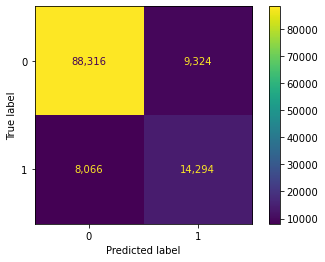

In [33]:
evaluate(clf, X_train, X_test, y_train, y_test)

Evaluate:

- Did better than model-less baseline
- Balance between false negs and false pos
- Obviously very overfit


## Model 2: Logistic Regression

In [40]:
logreg = LogisticRegression(solver='sag')

In [41]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', logreg)
])

In [42]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohencoder

Train Scores
------------
Accuracy: 0.8128645833333333
F1 Score: 0.02955888549172978
ROC-AUC: 0.6686840007645836
--------------------
Test Scores
-----------
Accuracy: 0.8137583333333334
F1 Score: 0.027754817940575112
ROC-AUC: 0.6697109746181622


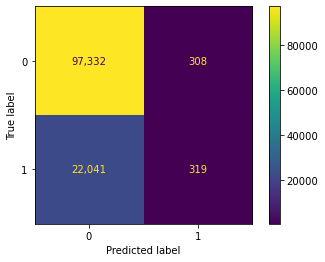

In [43]:
evaluate(clf, X_train, X_test, y_train, y_test)

Evaluate:

- Under-predicting the minority class 
- About the same as model-less baseline
- Not overfit at all


## Model 3: 

Why SVC? 

In [44]:
from sklearn.svm import SVC

In [45]:
svc = SVC()

In [46]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc)
])

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
evaluate(clf, X_train, X_test, y_train, y_test)

Evaluate:

- Takes a long time to train
- 
